In [1]:
%matplotlib inline

# Fitting individual SFR histories with the ${\tt diffmah}$ model

## Setup

To use `diffmah.utils.jax_adam_wrapper`, we need a differentiable implementation of `mse_loss(params, data)`, and we need the target `data` and initial guess `params_init`. These functions and data all implemented in the `fit_individual_sfr_history.py` module. 

First we get our target SFR and Mstar histories. For this we'll just use some non-fiducial model to generate the targets.

In [7]:
from fit_individual_sfr_history import get_mse_loss_data

logm0_target = 12.25
t_table = np.linspace(0.1, 13.85, 300)
t_fit = np.linspace(0.5, 13.85, 100)
param_dict_target = dict(
        lge0=-1.5, lgtc=0.5, lgec=0., a_late=-1., log_qtime=1.05, log_qfrac=-0.5,
        dmhdt_early_index=0.35)

mse_loss_data = get_mse_loss_data(logm0_target, t_table, t_fit, **param_dict_target)

For `params_init` we'll just use the fiducial model at a slightly different mass:

In [3]:
from fit_individual_sfr_history import get_model_param_dict, get_model_param_array
logm0_init = 12.2
params_init = get_model_param_array(logm0_init)
param_dict_init = get_model_param_dict(params_init)[1]

## Run the optimizer

Now we call the `jax_adam_wrapper` function and tell it how many steps to take:

In [4]:
from fit_individual_sfr_history import mse_loss

from diffmah.utils import jax_adam_wrapper

n_steps = 5000
params_bestfit, loss = jax_adam_wrapper(
    mse_loss, params_init, mse_loss_data, n_steps)

logm0_bestfit, param_dict_bestfit = get_model_param_dict(params_bestfit)

In [5]:
from diffmah.individual_sfr_history import individual_sfr_history

tplot = np.linspace(0.1, 14, 1000)

_x = individual_sfr_history(logm0_bestfit, tplot, **param_dict_bestfit)
log_sfr_best, log_sm_best = _x

_x = individual_sfr_history(logm0_init, tplot, **param_dict_init)
log_sfr_init, log_sm_init = _x

_x = individual_sfr_history(logm0_target, tplot, **param_dict_target)
log_sfr_target, log_sm_target = _x


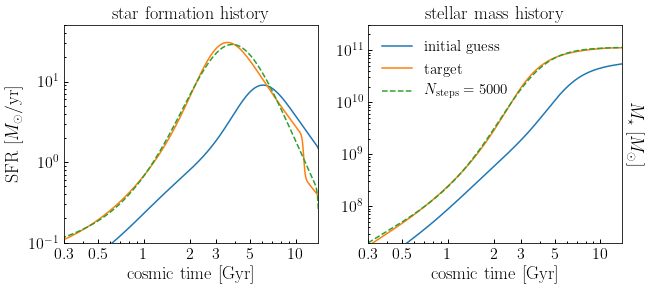

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
xlim = ax0.set_xlim(0.75, 13.85)
ylim0 = ax0.set_ylim(0.1, 50)
ylim1 = ax1.set_ylim(2e7, 3e11)
__=ax0.loglog()
__=ax1.loglog()
__=ax0.plot(tplot, 10**log_sfr_init, label=r'${\rm initial\ guess}$')
__=ax0.plot(tplot, 10**log_sfr_target, label=r'${\rm target}$')
__=ax0.plot(tplot, 10**log_sfr_best, '--', label=r'$N_{\rm steps}=5000$')

__=ax1.plot(tplot, 10**log_sm_init, label=r'${\rm initial\ guess}$')
__=ax1.plot(tplot, 10**log_sm_target, label=r'${\rm target}$')
__=ax1.plot(tplot, 10**log_sm_best, '--', label=r'$N_{\rm steps}=5000$')

leg1 = ax1.legend()

xlabel0 = ax0.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel1 = ax1.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel0 = ax0.set_ylabel(r'${\rm SFR}\ [M_{\odot}/{\rm yr}]$')
__=ax1.yaxis.set_label_position("right")  #  y-labels on the right
ylabel1 = ax1.set_ylabel(r'$M_{\star}\ [M_{\odot}]$', rotation=-90, labelpad=20)

title = ax0.set_title(r'${\rm star\ formation\ history}$')
title = ax1.set_title(r'${\rm stellar\ mass\ history}$')

from matplotlib import ticker
for ax in (ax0, ax1):
    __=ax.set_xticks((0.3, 0.5, 1, 2, 3, 5, 10))
    __=ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
    __=ax.set_xticklabels([r'$0.3$', r'$0.5$', r'$1$', r'$2$', r'$3$', r'$5$', r'$10$'])

fig.savefig('sfr_history_demo_fit.png', bbox_extra_artists=[xlabel0, ylabel0], 
            bbox_inches='tight', dpi=200)
